# Get historical bars from the Binance API

Content:

- Load libraries
- Function to get bars
- Create a dataframe
- Create a wrapper function
- Visualize the data

## Load libraries

First, we load some standard libraries to support the workflow.

In [27]:
# get standard libraries
import requests                    # for "get" request to API
import json                        # parse json into a list
import pandas as pd                # working with data frames
import datetime as dt              # working with dates
import matplotlib.pyplot as plt    # plot data

## Function to get bars

Here we define our funtion to get historical bars data.

Find the GitHub docs for the API here:
https://github.com/binance/binance-spot-api-docs/blob/master/rest-api.md

In [54]:
def get_binance_bars(symbol, interval, start_time, end_time, limit="1000"):
    """Get historical bars for a ticker from Binance
    
    Args:
        symbol (str): Binance symbol
        interval (str): Interval for historical data, e.g. '1h' for hourly bars
        start_time (datetime object): Start time of history
        end_time (datetime object): End time of history
        limit (str): Limit of number of lines for data request, defaulted to 1000
    
    Returns:
        df: pandas DataFrame object
        
    Exampls:
        >>> get_binance_bars('ETHEUR', '1h', dt.datetime(2020, 1, 1), dt.datetime(2020, 2, 1))
        
    """
    
    # define the binance url from data is requested
    url = "https://api.binance.com/api/v3/klines"
    
    # setting request params
    req_params = {'symbol': symbol,
                  'interval': interval,
                  'startTime': str(int(start_time.timestamp() * 1000)),
                  'endTime' : str(int(end_time.timestamp() * 1000)),
                  'limit' : str(limit)}
 
    # load request into a dataframe
    df = pd.DataFrame(json.loads(requests.get(url, params = req_params).text))
    if (len(df.index) == 0):
        return None     
    
    # transfrom dataframe
    df = df.iloc[:, 0:6]  # extract 
    df.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume'] 
    df.open = df.open.astype("float")
    df.high = df.high.astype("float")
    df.low = df.low.astype("float")
    df.close = df.close.astype("float")
    df.volume = df.volume.astype("float")
    df.index = [dt.datetime.fromtimestamp(x / 1000.0) for x in df.datetime]
 
    return df

In [115]:
# testing the function call
df = get_binance_bars('ETHEUR', '1h', dt.datetime(2020, 1, 1), dt.datetime(2020, 3, 1))
df.head()

,datetime,open,high,low,close,volume
2020-01-03 09:00:00,1578038400000,113.80,115.40,113.80,115.40,1.10270
2020-01-03 10:00:00,1578042000000,118.46,118.46,118.46,118.46,0.50000
2020-01-03 11:00:00,1578045600000,118.06,118.06,118.02,118.02,1.33288
2020-01-03 12:00:00,1578049200000,118.40,118.40,118.40,118.40,0.08539
2020-01-03 13:00:00,1578052800000,118.40,118.40,118.40,118.40,0.00000


<AxesSubplot:>

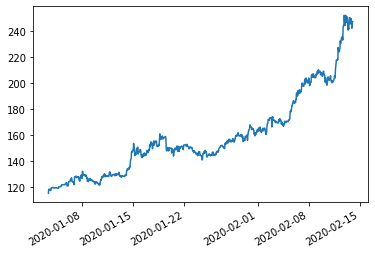

In [61]:
# check a visual for the data
df['close'].plot()

## Create a dataframe

As we only request a limited number of lines per API call, we create an iteration of calls that append data into a dataframe.

We want to write a process that load us data for multiple months in multiple years, for instance from 2019-10-01 to 2021-02-28.

In [140]:
# pick up start and end days
def generate_dates_list(start_date, end_date):
    """Generate a list of dates in daily interval
    
    Args:
        start_date (datetime object): start time as datetime object
        end_date (datetime object): end time as datetime object
        
    Returns:
        dates (list of datetime of objects): list of datetime objects in daily intervals

    Example:
        >>>generate_dates_list(dt.datetime(2020,12,31), dt.datetime(2021,1,1))
        [datetime.datetime(2020, 12, 31, 0, 0), datetime.datetime(2021, 1, 1, 0, 0)]
    """
    # count number of days between start and end
    nr_days = int(str((end_date - start_date).days))

    # prepare a list of dates for data retrieval
    dates = [start_date]
    for i in range(0, nr_days):
        start_date += dt.timedelta(days=1)
        dates.append(start_date)
    
    return dates

dates = generate_dates_list(dt.datetime(2019,10,1), dt.datetime(2021,2,28))

In [107]:
# Call the function for every day
df_list = [get_binance_bars
           (
               symbol = 'ETHUSDT',
               interval = '1h',
               start_time = date,
               end_time = date + dt.timedelta(days=1) - dt.timedelta(seconds=1)
           )
           for date
           in dates]

In [108]:
# Concatenate list of dfs in 1 df
DF = pd.concat(df_list)
DF.shape

(12387, 6)

In [116]:
DF.head()

,datetime,open,high,low,close,volume
2019-10-01 00:00:00,1569880800000,177.26,178.55,176.92,177.03,9205.65198
2019-10-01 01:00:00,1569884400000,177.04,181.24,177.02,180.85,23746.34438
2019-10-01 02:00:00,1569888000000,180.89,181.42,178.11,178.68,26745.60752
2019-10-01 03:00:00,1569891600000,178.67,182.14,177.75,181.39,32308.79538
2019-10-01 04:00:00,1569895200000,181.40,184.30,181.36,183.55,46645.70800


## Create a wrapper function

Let's bring it all together and put all the retrieval functionality in one function call.

In [117]:
def prepare_data(symbol, interval, start_time, end_time):
    # generate list of dates
    dates = generate_dates_list(start_time, end_time)
    
    # store data in a list of data frames
    df_list = [get_binance_bars
               (
                   symbol = symbol,
                   interval = interval,
                   start_time = date,
                   end_time = date + dt.timedelta(days=1) - dt.timedelta(seconds=1)
               )
               for date
               in dates]
    # Concatenate list of dfs in 1 df
    df = pd.concat(df_list)
    
    return df

eth_data = prepare_data("ETHEUR", "1h", dt.datetime(2021,1,1), dt.datetime(2021,1,10))
eth_data.head()

,datetime,open,high,low,close,volume
2021-01-01 00:00:00,1609455600000,605.75,606.58,601.49,603.38,868.47445
2021-01-01 01:00:00,1609459200000,603.25,605.76,599.52,601.81,1460.20282
2021-01-01 02:00:00,1609462800000,601.77,610.76,601.33,610.36,1468.92626
2021-01-01 03:00:00,1609466400000,610.49,611.00,605.86,606.75,647.21461
2021-01-01 04:00:00,1609470000000,606.82,609.08,606.10,607.50,140.36287


## Plot the data

<AxesSubplot:>

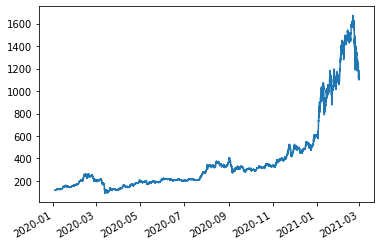

In [130]:
eth_data['close'].plot()

## Export data into a file

In [133]:
# retrieve data
eth_data = prepare_data("ETHEUR", "1h", dt.datetime(2020,3,1), dt.datetime(2021,2,28))

# export
eth_data.to_csv("../data/etheur_2020-03_2021-02_1h.csv")

In [135]:
# Run process in a loop
symbols = ["ETHEUR", "BTCEUR", "LTCEUR"]

for symbol in symbols:
    # retrieve data
    data = prepare_data(symbol, "1h", dt.datetime(2020,3,1), dt.datetime(2021,2,28))
    
    # store data
    filepath = f"../data/{symbol.lower()}_2020-03_2021-02_1h.csv"
    data.to_csv(filepath)